# FEAT 

In [1]:
from model.trainer.fsl_trainer import FSLTrainer
import pickle
args = pickle.load(open('args.pkl', 'rb')) # 导入参数

In [2]:
fsltrainer = FSLTrainer(args)

Namespace(max_epoch=200, episodes_per_epoch=100, num_eval_episodes=600, model_class='FEAT', use_euclidean=True, backbone_class='Res18', dataset='CUB', way=5, eval_way=5, shot=1, eval_shot=1, query=15, eval_query=15, balance=1.0, temperature=64.0, temperature2=16.0, orig_imsize=-1, lr=0.0001, lr_mul=10.0, lr_scheduler='step', step_size='20', gamma=0.5, fix_BN=False, augment=False, multi_gpu=False, gpu='0', init_weights=None, mom=0.9, weight_decay=0.0005, num_workers=4, log_interval=50, eval_interval=1, save_dir='./checkpoints', num_classes=5, save_path='./checkpoints\\CUB-FEAT-Res18-05w01s15q-DIS\\20_0.5_lr0.0001mul10_step_T164.0T216.0_b1.0_bsz080-NoAug', num_class=100)
<class 'argparse.Namespace'>


## 加载数据集

由于MiniImageNet数据集"To download this dataset, please email [Sachin Ravi](http://www.cs.princeton.edu/~sachinr/) for further details and instructions."，所以这里我下载了CUB数据集，对整个模型进行分析

### CUB数据集配置

- CUB有200类别
- 100类做训练集
- 50类做验证集
- 50类做测试集

In [3]:
data = fsltrainer.train_loader.dataset[0]

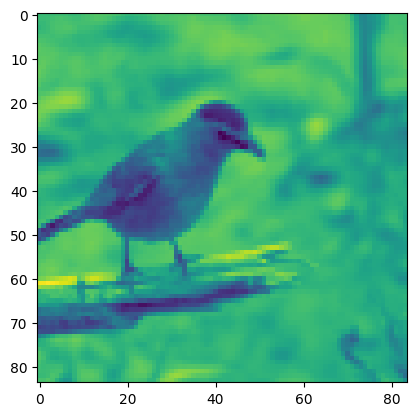

In [4]:
from matplotlib.pylab import plt
plt.imshow(data[0].numpy()[0])

## 模型测试
### 整体理解

In [5]:
j = 0
for i in fsltrainer.train_loader: #这里加载数据集的一个批次
    if j == 1: break
    data = i
    j += 1

In [6]:
from torchinfo import summary

summary(fsltrainer.model, (100, 3, 84, 84)) # 具体查看模型的训练框架

# 可以看出模型首先是ResNet18然后加了Transformer,这里的Transformer模型整体与VIT非常类似

Layer (type:depth-idx)                        Output Shape              Param #
FEAT                                          [75, 5]                   --
├─ResNet: 1-1                                 [100, 512]                --
│    └─Conv2d: 2-1                            [100, 64, 84, 84]         1,728
│    └─BatchNorm2d: 2-2                       [100, 64, 84, 84]         128
│    └─ReLU: 2-3                              [100, 64, 84, 84]         --
│    └─Sequential: 2-4                        [100, 64, 84, 84]         --
│    │    └─BasicBlock: 3-1                   [100, 64, 84, 84]         73,984
│    │    └─BasicBlock: 3-2                   [100, 64, 84, 84]         73,984
│    └─Sequential: 2-5                        [100, 128, 42, 42]        --
│    │    └─BasicBlock: 3-3                   [100, 128, 42, 42]        230,144
│    │    └─BasicBlock: 3-4                   [100, 128, 42, 42]        295,424
│    └─Sequential: 2-6                        [100, 256, 21, 21]        -

In [7]:
logit, reg_logit = fsltrainer.model(data[0])
label, label_aux = fsltrainer.prepare_label()

In [8]:
import torch.nn.functional as F
F.cross_entropy(logit, label) + args.balance * F.cross_entropy(reg_logit, label_aux)# 这样计算损失

tensor(2.9523, grad_fn=<AddBackward0>)

## 细致查看模型
### 数据处理
![](imgs/img1.png)

通过对比与源码可以看出，把100个类别训练集中的随机抽取N(5)个类作为一个小任务，这N个类分别有shot(1) + query(5)个样本，总共有100个任务

In [9]:
label

tensor([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3,
        4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2,
        3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1,
        2, 3, 4])

In [10]:
data[1] 

tensor([92, 34, 68, 40, 53, 92, 34, 68, 40, 53, 92, 34, 68, 40, 53, 92, 34, 68,
        40, 53, 92, 34, 68, 40, 53, 92, 34, 68, 40, 53, 92, 34, 68, 40, 53, 92,
        34, 68, 40, 53, 92, 34, 68, 40, 53, 92, 34, 68, 40, 53, 92, 34, 68, 40,
        53, 92, 34, 68, 40, 53, 92, 34, 68, 40, 53, 92, 34, 68, 40, 53, 92, 34,
        68, 40, 53, 92, 34, 68, 40, 53])

In [19]:
fsltrainer.model.split_instances(data[0]) #通过models.base的split_instances可以看出前5个为shot，后15个为query

(tensor([[[0, 1, 2, 3, 4]]]),
 tensor([[[ 5,  6,  7,  8,  9],
          [10, 11, 12, 13, 14],
          [15, 16, 17, 18, 19],
          [20, 21, 22, 23, 24],
          [25, 26, 27, 28, 29],
          [30, 31, 32, 33, 34],
          [35, 36, 37, 38, 39],
          [40, 41, 42, 43, 44],
          [45, 46, 47, 48, 49],
          [50, 51, 52, 53, 54],
          [55, 56, 57, 58, 59],
          [60, 61, 62, 63, 64],
          [65, 66, 67, 68, 69],
          [70, 71, 72, 73, 74],
          [75, 76, 77, 78, 79]]]))

### ResNet18

通过summary可以发现，ResNet18的输出维度为[80, 512]，一般的ResNet18再加线性层就可以把结果[10, 512]映射成类别[10, N]，然后用softmax得到取最大值就是结果

In [13]:
summary(fsltrainer.model.encoder, (10, 3, 84, 84))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [10, 512]                 --
├─Conv2d: 1-1                            [10, 64, 84, 84]          1,728
├─BatchNorm2d: 1-2                       [10, 64, 84, 84]          128
├─ReLU: 1-3                              [10, 64, 84, 84]          --
├─Sequential: 1-4                        [10, 64, 84, 84]          --
│    └─BasicBlock: 2-1                   [10, 64, 84, 84]          --
│    │    └─Conv2d: 3-1                  [10, 64, 84, 84]          36,864
│    │    └─BatchNorm2d: 3-2             [10, 64, 84, 84]          128
│    │    └─ReLU: 3-3                    [10, 64, 84, 84]          --
│    │    └─Conv2d: 3-4                  [10, 64, 84, 84]          36,864
│    │    └─BatchNorm2d: 3-5             [10, 64, 84, 84]          128
│    │    └─ReLU: 3-6                    [10, 64, 84, 84]          --
│    └─BasicBlock: 2-2                   [10, 64, 84, 84]          --
│

## Transformer模型


In [23]:
instance_embs = fsltrainer.model.encoder(data[0]) # ResNet18
support_idx, query_idx = fsltrainer.model.split_instances(data[0]) # 前5为support, 后75个为query

In [52]:
emb_dim = instance_embs.size(-1) #得到ResNet18输出的值维度

In [26]:
support = instance_embs[support_idx.contiguous().view(-1)].contiguous().view(*(support_idx.shape + (-1,)))
query   = instance_embs[query_idx.contiguous().view(-1)].contiguous().view(  *(query_idx.shape   + (-1,)))

In [39]:
support.shape, query.shape #可以看出这个时候support维度为[task, shot, way, 512], query为[task, query, way, 512]

(torch.Size([1, 1, 5, 512]), torch.Size([1, 15, 5, 512]))

In [44]:
import numpy as np
proto = support.mean(dim=1) # 维度为[task, way, 512]
num_batch = proto.shape[0] #获取task数
num_proto = proto.shape[1] #获取way数
num_query = np.prod(query_idx.shape[-2:]) # 获取query
# query: (num_batch, num_query, num_proto, num_emb)
# proto: (num_batch, num_proto, num_emb)

In [49]:
proto = fsltrainer.model.slf_attn(proto, proto, proto)   #slf_attn就是自注意力机制, 这里就是set-to-set调整函数

In [50]:
proto

tensor([[[ 0.2509,  0.0292, -0.0971,  ..., -0.0252, -0.2329,  0.0623],
         [ 0.4505, -0.5775, -1.4737,  ...,  0.0308,  0.4450,  0.1237],
         [ 0.0225, -0.6368, -1.4772,  ...,  0.0953,  0.4120,  0.1324],
         [ 0.1256,  0.3600, -1.4954,  ...,  0.2798,  0.2907,  2.6940],
         [-0.0812,  0.2654, -0.9731,  ..., -2.5553,  0.0413,  0.1698]]],
       grad_fn=<NativeLayerNormBackward0>)

```py
if self.args.use_euclidean:
    query = query.view(-1, emb_dim).unsqueeze(1) # (Nbatch*Nq*Nw, 1, d)
    proto = proto.unsqueeze(1).expand(num_batch, num_query, num_proto, emb_dim).contiguous()
    proto = proto.view(num_batch*num_query, num_proto, emb_dim) # (Nbatch x Nq, Nk, d)

    logits = - torch.sum((proto - query) ** 2, 2) / self.args.temperature
    else:
        proto = F.normalize(proto, dim=-1) # normalize for cosine distance
        query = query.view(num_batch, -1, emb_dim) # (Nbatch,  Nq*Nw, d)

        logits = torch.bmm(query, proto.permute([0,2,1])) / self.args.temperature
        logits = logits.view(-1, num_proto)
```
这里源码是两种相似度衡量方法，第一个是几何距离，第二个是余弦距离，我们按照默认选项，即余弦距离。

余弦距离:
$$cos_{sim} = \frac{\vec{a}\vec{b}}{|a||b|}$$

In [58]:
import torch
proto = F.normalize(proto, dim=-1) # 正则化操作，\vec{a} / |a|
query = query.view(num_batch, -1, emb_dim) # [num_batch, query * way, 512]
logits = torch.bmm(query, proto.permute([0,2,1])) / args.temperature #计算余弦距离
logits = logits.view(-1, num_proto) #得到相似度

In [59]:
logits.shape

torch.Size([75, 5])

## 正则化
![](imgs/img2.png)

这里把support也加入了计算相似度的过程，上面计算相似度logits是query与support相似度，而这里logits_reg是support + query与support相似度，最后用正则化公式，把logits_reg作为惩罚项，可以保证模型有足够泛化能力

In [67]:
F.cross_entropy(logit, label) + args.balance * F.cross_entropy(reg_logit, label_aux)# 这样计算损失

tensor(2.9523, grad_fn=<AddBackward0>)